# CMSC426 HW02, Shiyuan Duan

In this homework we will be exploring cluster alghrithm by using a single guassian to cluster data and a gaussian mixture model. 

We start from implementing some helper functions that helps us to visualize our data and result

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

In [2]:
def confidence_ellipse(mu, cov, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mu[0]

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mu[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

Now we start to look at what does our dataset look like:

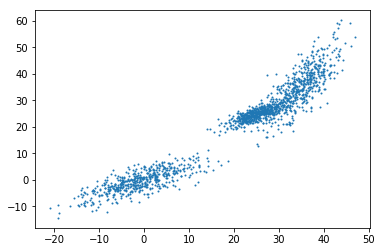

In [3]:
dataset = np.loadtxt('./data.csv', delimiter=',')
X = dataset[:,0]
Y = dataset[:,1]
plt.scatter(X,Y,s=1)
plt.show()

## Problem1

Usually gaussian models are good at clustering points. We start from exploring if a single gaussian model is sufficient to cluster points in this problem

To do this, first we have to find the mean and the covariance matrix inorder to plot a gaussian model

In [4]:
means = np.mean(dataset, axis = 0)
cov1 = np.cov(np.transpose(dataset))

Then we can visualize what the gaussian looks like. We can also plot a 3d histogram for our data points to see if the gaussian model expressive enough to cluster our points

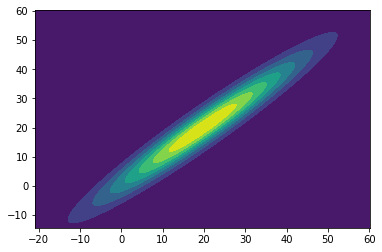

In [5]:
rv = multivariate_normal(means, cov1)

x, y = np.mgrid[min(X):max(Y):.01, min(Y):max(Y):.01]
pos = np.dstack((x, y))
rv = multivariate_normal(means, cov1)
plt.contourf(x, y, rv.pdf(pos))
plt.show()

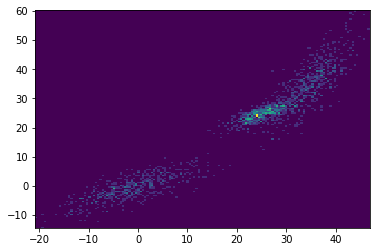

In [6]:
plt.hist2d(X, Y, bins=(150,150))
plt.show()

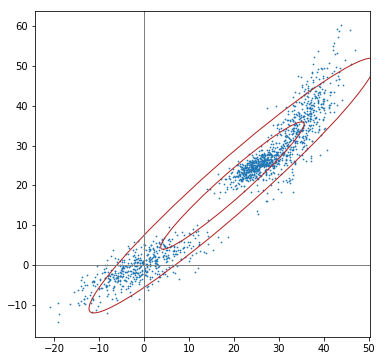

In [7]:
fig, ax_nstd = plt.subplots(figsize=(6, 6))

dependency_nstd = np.array([
    [0.8, 0.75],
    [-0.2, 0.35]
])

scale = 8, 5

ax_nstd.axvline(c='grey', lw=1)
ax_nstd.axhline(c='grey', lw=1)


ax_nstd.scatter(X, Y, s=0.5)

confidence_ellipse(means,cov1, ax_nstd, n_std=1,
    label=r'$1\sigma$', edgecolor='firebrick')
confidence_ellipse(means,cov1, ax_nstd, n_std=2,
    label=r'$1\sigma$', edgecolor='firebrick')
plt.show()

From the graphs shown above we can clearly see that the single gaussian model is not sufficient to cluster our dataset. Therefore we have to explore how to cluster our dataset with a mixture of 3 gaussian models.

## Problem2 - Gaussian Mixture model

We will be using a mixture of 3 gaussian models. Therefore we have to calculate 3 sets of means and covariance matrix. The idea behind this is that we want to find an optimized set of means and covariance such that it maximizes the sum of pdf in all 3 models for all data points. 

To do this, we have to initialize our parameters. Here we are initializing our means by randomly selecting 3 points from our dataset. We also want to initialize a covariance matrix that is large so it will cover a wide range of data points. For $\pi$ we initialize it as 0.33 because each model is equal likely at the begining. 

In [8]:
import random
dataset = np.loadtxt('./data.csv', delimiter=',')
n = len(dataset)
sample_dataset = list(dataset)
mu = random.sample(sample_dataset,3)
mu = np.array(mu)

sig = np.zeros((3,2,2))
sig = np.array([cov1 for i in range(3)])

pi = np.ones((3,1))/3

#normal distributions
pdf_m = np.zeros((3,n))

After initializing the parameters, we can start to optimize it. We want a set of means and covariance such that the sum of pdf in each model for all data points is maximized. 

The following shows how is each step done. This algrithm is a recurrsive algrithm so we need to do it in a loop

### Maxmizing $\mu$

To maxmize mu we need to get a gamma matrix that shows the posterior. Then we follow that math

In [9]:
rvs = [multivariate_normal(mu[i], sig[i]) for i in range(3)]
pdf_m = np.array([rvs[i].pdf(dataset) for i in range(3)])

gamma = pdf_m*pi
gamma_row = [np.sum(gamma[:,i]) for i in range(n)]
gamma = gamma / gamma_row

mu_numerator = gamma@dataset
mu_denominator = np.array([np.sum(gamma[i]) for i in range(3)])
mu_denominator = np.reshape(mu_denominator,(3,1))
mu = mu_numerator/mu_denominator

### Maxmizing $\Sigma$

In [10]:
new_dataset1 = (np.vstack((X-mu[0][0],Y-mu[0][1])).T) * np.reshape(gamma[0],(n,1))
new_dataset2 = (np.vstack((X-mu[1][0],Y-mu[1][1])).T) * np.reshape(gamma[1],(n,1))
new_dataset3 = (np.vstack((X-mu[2][0],Y-mu[2][1])).T) * np.reshape(gamma[2],(n,1))

sig[0] = np.dot(new_dataset1.T, new_dataset1)/mu_denominator[0]
sig[1] = np.dot(new_dataset2.T, new_dataset2)/mu_denominator[1]
sig[2] = np.dot(new_dataset3.T, new_dataset3)/mu_denominator[2]

### Maxmizing $\pi$

In [11]:
pi = np.array([np.sum(gamma[i]) for i in range(3)])
pi /= n
pi = np.reshape(pi, (3,1))

### Looping

In [13]:
for i in range(1000):
    # mu
    rvs = [multivariate_normal(mu[i], sig[i]) for i in range(3)]
    pdf_m = np.array([rvs[i].pdf(dataset) for i in range(3)])

    gamma = pdf_m*pi
    gamma_row = [np.sum(gamma[:,i]) for i in range(n)]
    gamma = gamma / gamma_row

    mu_numerator = gamma@dataset
    mu_denominator = np.array([np.sum(gamma[i]) for i in range(3)])
    mu_denominator = np.reshape(mu_denominator,(3,1))
    #print(np.linalg.norm(mu-(mu_numerator/mu_denominator)))
    mu = mu_numerator/mu_denominator
    
    # sig
    new_dataset1 = (np.vstack((X-mu[0][0],Y-mu[0][1])).T) * np.reshape(gamma[0],(n,1))
    new_dataset2 = (np.vstack((X-mu[1][0],Y-mu[1][1])).T) * np.reshape(gamma[1],(n,1))
    new_dataset3 = (np.vstack((X-mu[2][0],Y-mu[2][1])).T) * np.reshape(gamma[2],(n,1))

    sig[0] = np.dot(new_dataset1.T, new_dataset1)/mu_denominator[0]
    sig[1] = np.dot(new_dataset2.T, new_dataset2)/mu_denominator[1]
    sig[2] = np.dot(new_dataset3.T, new_dataset3)/mu_denominator[2]
    #print(sig)
    
    #pi
    pi = np.array([np.sum(gamma[i]) for i in range(3)])
    pi /= n
    pi = np.reshape(pi, (3,1))
    


After applying this algrithm in a loop we can see that we've already get a small value between mu in each loop. Therefore our parameters are well optimized. Now we can plot it and see how well our optimized GMM fits our data.

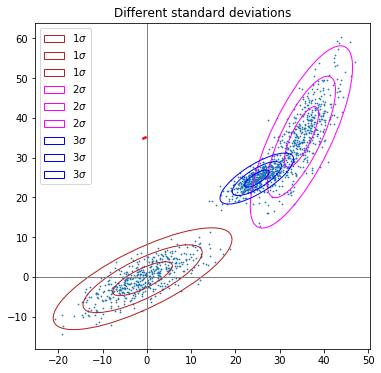

In [14]:
fig, ax_nstd = plt.subplots(figsize=(6, 6))

dependency_nstd = np.array([
    [0.8, 0.75],
    [-0.2, 0.35]
])

scale = 8, 5

ax_nstd.axvline(c='grey', lw=1)
ax_nstd.axhline(c='grey', lw=1)


ax_nstd.scatter(X, Y, s=0.5)

confidence_ellipse(mu[0],sig[0], ax_nstd, n_std=1,
    label=r'$1\sigma$', edgecolor='firebrick')
confidence_ellipse(mu[0],sig[0], ax_nstd, n_std=2,
    label=r'$1\sigma$', edgecolor='firebrick')
confidence_ellipse(mu[0],sig[0], ax_nstd, n_std=3,
    label=r'$1\sigma$', edgecolor='firebrick')


confidence_ellipse(mu[1], sig[1], ax_nstd, n_std=1,
    label=r'$2\sigma$', edgecolor='fuchsia')
confidence_ellipse(mu[1], sig[1], ax_nstd, n_std=2,
    label=r'$2\sigma$', edgecolor='fuchsia')
confidence_ellipse(mu[1], sig[1], ax_nstd, n_std=3,
    label=r'$2\sigma$', edgecolor='fuchsia')



confidence_ellipse(mu[2], sig[2], ax_nstd, n_std=1,
    label=r'$3\sigma$', edgecolor='blue')

confidence_ellipse(mu[2], sig[2], ax_nstd, n_std=2,
    label=r'$3\sigma$', edgecolor='blue')

confidence_ellipse(mu[2], sig[2], ax_nstd, n_std=3,
    label=r'$3\sigma$', edgecolor='blue')


ax_nstd.scatter(mu[0], mu[1], c='red', s=3)
ax_nstd.set_title('Different standard deviations')
ax_nstd.legend()
plt.show()

Here we can see that a gaussian mixture model is better than a single gaussian model becuase it can cluster and classifies more classes in the dataset. It can be a powerful algrithm in classification problems

#### Limitations

GMM model is powerful however it has lots of limitations. For example when dataset has a higher dimension like 6 or 7, GMM is really computationally expensive. Also a huge limitation for GMM is that programers have to know the right number of gaussian models to use ahead of time. In this problem we know that there are 3 classes of points so we can pick 3 gaussian models. However if we do not know that and we pick 2 gaussian models, we will fail in this classfication problem. For example if we use 2 gaussian models.

In [15]:
dataset = np.loadtxt('./data.csv', delimiter=',')
n = len(dataset)
sample_dataset = list(dataset)
mu = random.sample(sample_dataset,2)
mu = np.array(mu)

sig = np.zeros((2,2,2))
sig = np.array([cov1 for i in range(2)])

pi = np.ones((2,1))/2

#normal distributions
pdf_m = np.zeros((2,n))
for i in range(1000):
    # mu
    rvs = [multivariate_normal(mu[i], sig[i]) for i in range(2)]
    pdf_m = np.array([rvs[i].pdf(dataset) for i in range(2)])

    gamma = pdf_m*pi
    gamma_row = [np.sum(gamma[:,i]) for i in range(n)]
    gamma = gamma / gamma_row

    mu_numerator = gamma@dataset
    mu_denominator = np.array([np.sum(gamma[i]) for i in range(2)])
    mu_denominator = np.reshape(mu_denominator,(2,1))
    #print(np.linalg.norm(mu-(mu_numerator/mu_denominator)))
    mu = mu_numerator/mu_denominator
    
    # sig
    new_dataset1 = (np.vstack((X-mu[0][0],Y-mu[0][1])).T) * np.reshape(gamma[0],(n,1))
    new_dataset2 = (np.vstack((X-mu[1][0],Y-mu[1][1])).T) * np.reshape(gamma[1],(n,1))
    #new_dataset3 = (np.vstack((X-mu[2][0],Y-mu[2][1])).T) * np.reshape(gamma[2],(n,1))

    sig[0] = np.dot(new_dataset1.T, new_dataset1)/mu_denominator[0]
    sig[1] = np.dot(new_dataset2.T, new_dataset2)/mu_denominator[1]
    #sig[2] = np.dot(new_dataset3.T, new_dataset3)/mu_denominator[2]
    #print(sig)
    
    #pi
    pi = np.array([np.sum(gamma[i]) for i in range(2)])
    pi /= n
    pi = np.reshape(pi, (2,1))

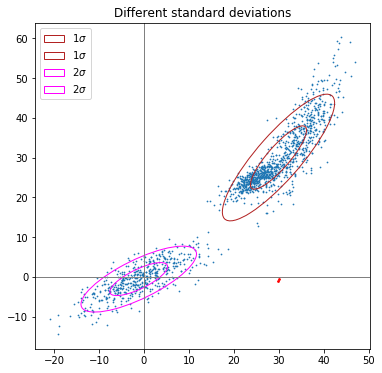

In [16]:
fig, ax_nstd = plt.subplots(figsize=(6, 6))

dependency_nstd = np.array([
    [0.8, 0.75],
    [-0.2, 0.35]
])

scale = 8, 5

ax_nstd.axvline(c='grey', lw=1)
ax_nstd.axhline(c='grey', lw=1)


ax_nstd.scatter(X, Y, s=0.5)

confidence_ellipse(mu[0],sig[0], ax_nstd, n_std=1,
    label=r'$1\sigma$', edgecolor='firebrick')
confidence_ellipse(mu[0],sig[0], ax_nstd, n_std=2,
    label=r'$1\sigma$', edgecolor='firebrick')



confidence_ellipse(mu[1], sig[1], ax_nstd, n_std=1,
    label=r'$2\sigma$', edgecolor='fuchsia')
confidence_ellipse(mu[1], sig[1], ax_nstd, n_std=2,
    label=r'$2\sigma$', edgecolor='fuchsia')


ax_nstd.scatter(mu[0], mu[1], c='red', s=3)
ax_nstd.set_title('Different standard deviations')
ax_nstd.legend()
plt.show()

We can see that in this case we only classfied 2 set of points and failed to classify the top right corner. 

If we choose a large number of guassian instead. Not only it will be computationally expensive but also over fit or over cluster our datset. Therefore GMM is limited and can be used only if the number of classes is known ahead of the time